The goal of this notebook is to **use Google's GTFS data to find out how many trains are operating in the NYC Subway at any given time**. Along the way, we will also how frequency changes throughout the train schedule and examine how frequency interacts with ridership numbers.

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [1]:
import pandas as pd
import geopandas as gpd
from geodatasets import get_path
import shapely
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import os
import sys
import glob
# from natsort import natsorted #using this to sort files numerically instead of alphabetically
import imageio
from PIL import Image
import warnings
warnings.filterwarnings(action='ignore')
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import tab20
mpl.rcParams['figure.dpi'] = 150

In [2]:
# getting functions from the parent directory
library_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if library_path not in sys.path:
    sys.path.append(library_path)
from functions import *

# Schedule Data

In [3]:
routes_df = pd.read_csv("../data/google_transit/routes.txt")
stop_times_df = pd.read_csv("../data/google_transit/stop_times.txt")
stops_df = pd.read_csv("../data/google_transit/stops.txt")

## Frequency Data 
(that I made)

In [4]:
trip_interval_route_freq = pd.read_csv("../saved_data/trip_interval_route_freq.csv", index_col=0)
route_frequency_by_day = pd.read_csv("../saved_data/route_frequency_by_day.csv", index_col=0)
station_info_w_frequency = pd.read_csv("../saved_data/station_info_w_frequency.csv", index_col=0)
stations_df = pd.read_csv("../saved_data/stations_df.csv", index_col=0)
orig_stations_df = pd.read_csv("../data/MTA_Subway_Stations_20240325.csv", index_col=0)
station_complex_full_info = pd.read_csv("../saved_data/station_info_w_frequency.csv", index_col=0)

In [5]:
# sorting the trip interval data by service
# sorting train_time_interval by time of day
time_of_day_sorting = {'Late Night': 0, 'Rush Hour AM': 1, 'Midday': 2
                                     , 'Rush Hour PM': 3, 'Evening': 4, 'Weekend': 5}
trip_interval_route_freq = trip_interval_route_freq.sort_values(by= ['route_id', 'train_time_interval']
                                    , key=lambda x: x.map(time_of_day_sorting)).reset_index(drop=True)

## Mapping GeoDataFrame

In [6]:
path_to_file = get_path('nybb')
boros = gpd.read_file(path_to_file).to_crs(epsg=3857)

## Removing SIR 

In [7]:
station_info_w_frequency = station_info_w_frequency[station_info_w_frequency['Borough']!='SI']
stations_df = stations_df[stations_df['Borough']!='SI']
orig_stations_df = orig_stations_df[orig_stations_df['Borough']!='SI']
station_complex_full_info = station_complex_full_info[station_complex_full_info['Borough']!='SI']
boros = boros[boros['BoroName']!='Staten Island']

# GeoData Transformations

In [8]:
orig_stations_df['GTFS Latitude'] = [x.split(" ")[1][1:] for x in orig_stations_df['Georeference']]
orig_stations_df['GTFS Longitude'] = [x.split(" ")[2][:-1] for x in orig_stations_df['Georeference']]
geometries = [shapely.Point(x,y) for x,y in list(zip(orig_stations_df['GTFS Latitude'], orig_stations_df['GTFS Longitude']))]
orig_stations_df['geometry'] = geometries

In [9]:
orig_stations_gdf = gpd.GeoDataFrame(orig_stations_df)
orig_stations_gdf = orig_stations_gdf.dissolve(by='Complex ID').reset_index()
orig_stations_gdf['geometry'] = orig_stations_gdf.geometry.centroid
orig_stations_gdf = orig_stations_gdf.set_crs(epsg=4326).to_crs(epsg=3857)
orig_stations_gdf = orig_stations_gdf.sort_values(by='Complex ID')

In [10]:
complex_tph = station_complex_full_info.groupby('Complex ID')['trains_per_hour'].sum().reset_index()

In [11]:
len(orig_stations_gdf)

424

In [12]:
len(complex_tph)

424

In [13]:
# adding the rank of the station in terms of trains per hour on a 1-10 scale
# station_complex_full_info['TPH_percent_rank'] = station_complex_full_info['trains_per_hour'].rank(pct=True)
# station_complex_full_info = station_complex_full_info.sort_values(by='GTFS Stop ID')
# stations_geodataframe = gpd.GeoDataFrame(station_complex_full_info
#                                         , geometry=geometries)

In [14]:
# checking to see if the IDs match between the two pandas objects
if any(orig_stations_gdf['Complex ID'] == complex_tph['Complex ID']):
    orig_stations_gdf['tph'] = complex_tph['trains_per_hour']
else:
    print("Please check that the two pandas objects are aligned correctly")

# Getting TPH for each Station
note that we're using stations for this analysis and not complexes

## Overall (non late night) Frequency

Text(0, 0.5, 'Trains per Hour')

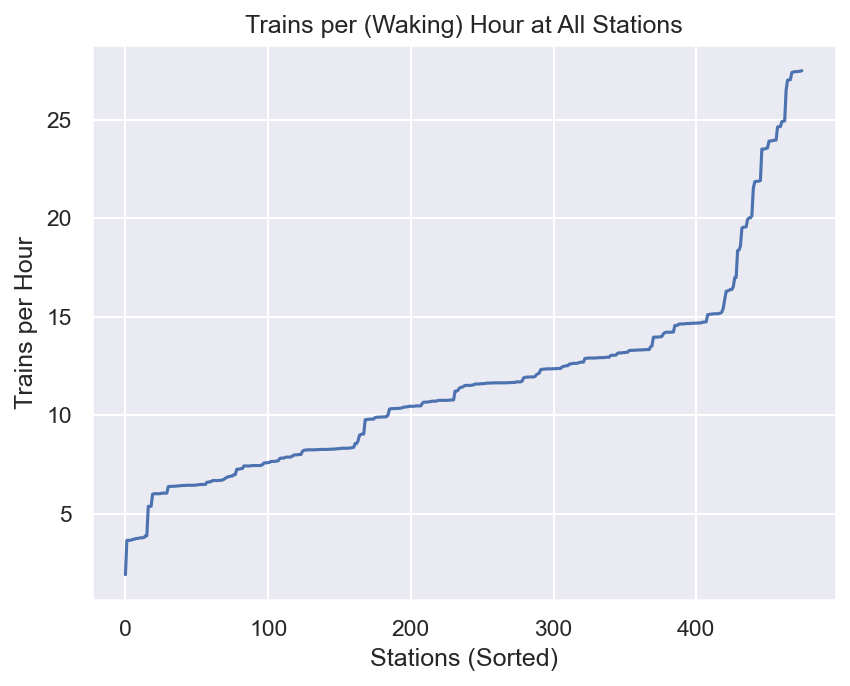

In [15]:
ax = station_info_w_frequency['trains_per_hour'].sort_values().plot(
    use_index=False, title="Trains per (Waking) Hour at All Stations")
ax.set_xlabel('Stations (Sorted)')
ax.set_ylabel('Trains per Hour')
# plt.savefig("saved_data/station_tph.png") 

# X Minute City 
What parts of nyc have subway accessibility?

In [16]:
stations_geodataframe_15 = orig_stations_gdf.copy()
stations_geodataframe_15[f'distance_in_15'] = x_minute_subway(orig_stations_gdf, 15)
stations_geodataframe_15['geometry'] = stations_geodataframe_15['geometry'].buffer(
                        stations_geodataframe_15['distance_in_15'])

common_area = boros['geometry'].intersection(stations_geodataframe_15['geometry'].unary_union)
difference_area = boros['geometry'].difference(stations_geodataframe_15['geometry'].unary_union)

<Axes: title={'center': 'Areas of NYC with <15 Minute Subway Service'}>

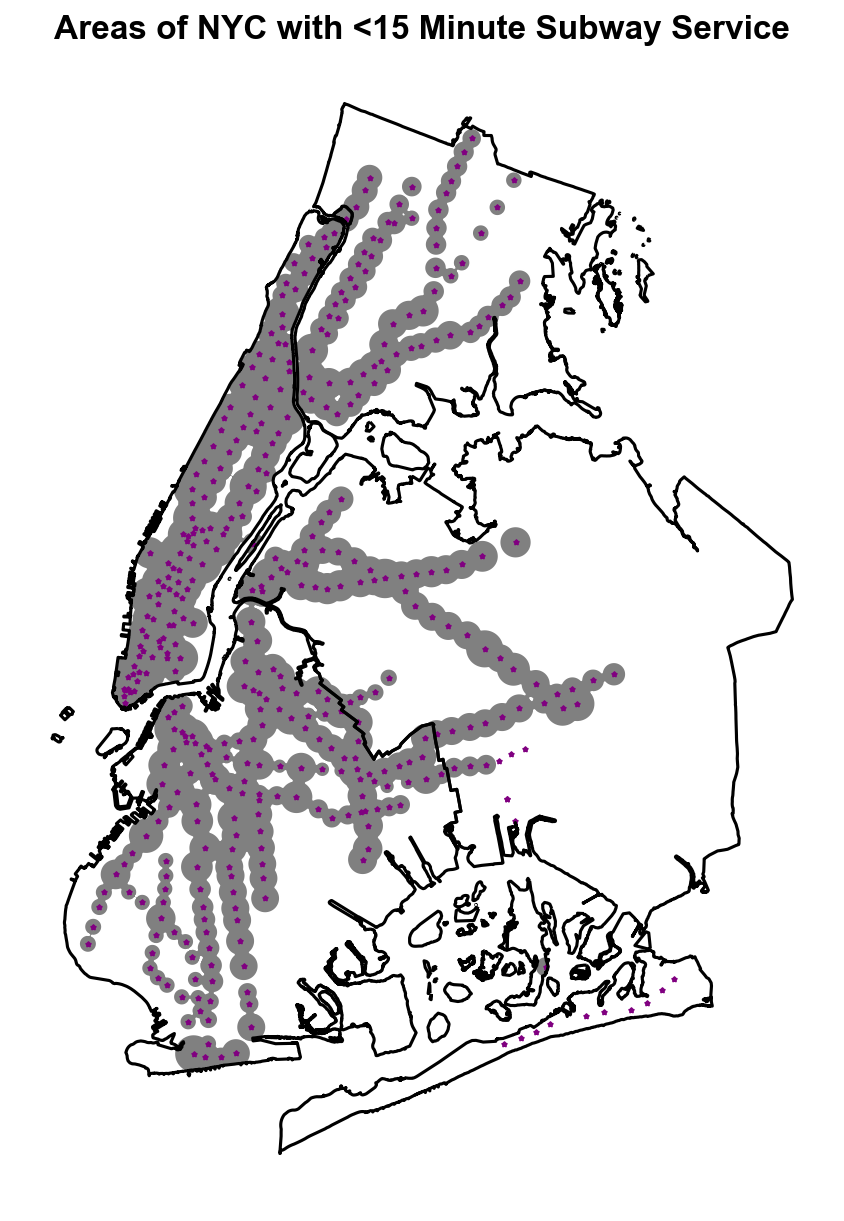

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.set_title("Areas of NYC with <15 Minute Subway Service", color='black', fontsize=16, weight='bold')
boros.boundary.plot(ax=ax, color="black")
common_area.plot(color='grey', ax=ax)
# stations
orig_stations_gdf['geometry'].plot(marker='*', color='purple', markersize=5, ax=ax)
# plt.savefig("../saved_data/15_minute_city.jpg") 

## GIF using normal geopandas plot 

In [18]:
output_path = "../saved_data/x_minute_city_gif/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [19]:
for idx, number in enumerate(range(0, 310, 25)):
    number = number / 10 # adjusting for the multiplication needed to make the range function to work 
    # making the number integers (if possible)
    if int(number) != number:
        pass 
    else:
        number = int(number)
    # distance data 
    new_stations_geodataframe = orig_stations_gdf.copy()
    new_stations_geodataframe[f'distance_in_{number}'] = x_minute_subway(orig_stations_gdf, number)
    new_stations_geodataframe['geometry'] = new_stations_geodataframe['geometry'].buffer(
                                            new_stations_geodataframe[f'distance_in_{number}'])
    
    common_area = boros['geometry'].intersection(new_stations_geodataframe['geometry'].unary_union)
    difference_area = boros['geometry'].difference(new_stations_geodataframe['geometry'].unary_union)
    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.axis('off')
    if number == 0:
        ax.set_title(f"NYC Subway Stations", color='black', fontsize=16, weight='bold')
    else:
        ax.set_title(f"Areas of NYC with <{number} Minute Subway Service", color='black', fontsize=16, weight='bold')
    boros.boundary.plot(ax=ax, color="black")
    # common_area.plot(color='grey', edgecolor='purple', ax=ax)
    difference_area.plot(color='grey', edgecolor='purple', ax=ax)   
    # stations
    orig_stations_gdf['geometry'].plot(marker='*', color='purple', markersize=5, ax=ax)
    if idx >= 10:
        idx = 'a' + str(idx)
    filepath = os.path.join(output_path, str(idx) + '_' + str(number) + '_minute_city' + ".png")
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()

In [20]:
images = []
for file_name in sorted(glob.glob(f'{output_path}/*.png')):
    images.append(imageio.imread(file_name))
imageio.mimsave(f'{output_path}/movie.gif', images, fps=0.9)